[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[ 1.  -1. ]
 [ 2.   0.5]]
12.0
(320, 240, 1)


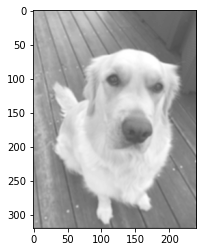

In [2]:
import numpy as np

A = np.reshape(np.arange(0, 25), (5, 5))
K = np.array([1., -1., 2., .5]).reshape((2, 2))

print(A)
print(K)

print((A[0:2, 0:2] * K).sum())

# Des exemples de filtres de convolution utilisés en image
# (les plus courageux pourront les utiliser à la main sur des images)
# construct a sharpening filter
sharpen = np.array((
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]), dtype="int")

# construct the Laplacian kernel used to detect edge-like
# regions of an image
laplacian = np.array((
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]), dtype="int")

# construct the Sobel x-axis kernel
sobelX = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int")

# construct the Sobel y-axis kernel
sobelY = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int")


# A remplir
def myconvolve2D(A, K):
    conv_result = np.zeros_like(A)
    h, w = A.shape
    ks = K.shape[0]
    kc = ks // 2
    for i in range(h):
        for j in range(w):
            for u in range(-1, kc + 1):
                for v in range(-1, kc + 1):
                    if not (0 <= i + u < h) or not (0 <= j + v < w):
                        continue
                    conv_result[i, j] += A[i + u, j + v] + K[kc + u, kc + v]
    return conv_result


from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img("chien.jpg", color_mode='grayscale')
x = image.img_to_array(img)
print(x.shape)
plt.imshow(myconvolve2D(x[:, :, 0] / 255., sobelX), cmap='gray')
plt.show()

#Res = 
#for x in range

# TD 07 / 1 -- Le classique MNIST

Dans ce TD nous allons mettre en oeuvre l'apprentissage sur les filtres de convolution. Nous le ferons sur la base d'exemple très connue (et très utilisée) MNIST. L'avantage est que cette base est directement disponible dans la distribution de Keras.



In [3]:
''' First part of the work: Read and explore the data
'''
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7, 7)  # Make the figures a bit bigger

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("x_train original shape", x_train.shape)
print("y_train original shape", y_train.shape)

x_train original shape (60000, 28, 28)
y_train original shape (60000,)


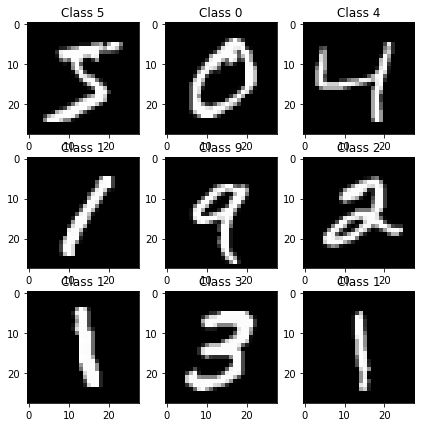

In [4]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

plt.show()


In [5]:
# We need an additional work to prepare the input images
x2_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x2_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print("x_train re-shaped", x2_train.shape)


x_train re-shaped (60000, 28, 28, 1)


## Exploration des données

- Dans un premier temps, vérifiez combien d'éléments sont dans chaque classe
- Normalisez les valeurs en entrée pour exprimer les pixels entre 0 et 1 (vous pourrez également essayer de normaliser autour de 0)

### Préparation du *hot-encoding* en sortie

Il s'agit de notre premier réseau neuronal ayant des catégories en sortie. Nous ne devons pas prédire un nombre entre 0 et 9 mais un vecteur de probabilités `Y[0..9]` tel que `Y[i] = p` signifie que le chiffre est `i` avec la probabilité `p`
- utilisez la fonction `keras.utils.to_categrical()` pour que `y_train` et `y_test`correspondent à des encodages en *hot encoding*


In [6]:
for i in range(10):
    print(i, ":", np.count_nonzero(np.where(y_train == i)))

x_train[0]

0 : 5923
1 : 6742
2 : 5958
3 : 6131
4 : 5842
5 : 5420
6 : 5918
7 : 6265
8 : 5851
9 : 5949


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [9]:
x2_train = x2_train.astype('float32')
x2_test = x2_test.astype('float32')
x2_train /= 255
x2_test /= 255
print('x2_train shape:', x2_train.shape)
print(x2_train.shape[0], 'train samples')
print(x2_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y2_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y2_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

print(y_train[0])
print(y2_train[0])

x2_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 1 - Faites sans convolution

Construisez un réseau de neurones uniquement avec des couches Dense (de 5-6 couches maxis). Comptez le nombre de neurones et cherchez des paramètres permettant d'avoir déjà des performances correctes.
- Cherchez à minimiser le nombre de couches et de de neurones par couches pour avoir des résultats ayant quasi la même qualité

*Attention*
- les couches Dense vont peut être vous obliger à mettre vos images en entrée sous forme de vecteur d'abord
- il faut définir le modèle puis faire l'apprentissage.


In [8]:
print(x2_test.shape)
x3_train = x2_train.reshape((x2_train.shape[0], 28 * 28))
x3_test = x2_test.reshape((x2_test.shape[0], 28 * 28))

model1 = Sequential()

# ... A REMPLIR

model1.summary()
epochs = 24

model1.fit(x3_train, y2_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x3_test, y2_test))
score = model1.evaluate(x3_test, y2_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


(10000, 28, 28, 1)


ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
# Essayez un autre modèle
model2 = Sequential()

model2.summary()
epochs = 20

model2.fit(x3_train, y2_train,
           batch_size=batch_size,
           epochs=epochs,
           verbose=1,
           validation_data=(x3_test, y2_test))
score = model2.evaluate(x3_test, y2_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


## 2 - Construisez LeNet5

![](./lenet5-architecture.png)

Définissez le modèle d'apprentissage suivant le modèle ci-dessus, et relancez l'apprentissage sur ce modèle
- Comparez le nombre de paramètres dans les premières couches avec le nombre de paramètres de l'exemple précédent

*Indication* : les *kernel* sont de taille `3x3` sans padding (on pourrait le retrouver en observant les dimensions des images).
* Attention* la résolution des images MNIST en entrée dans Keras est de 28x28 et non 32x32. 

- Prenez le temps de compter *à la main* le nombre de paramètres du réseau dans les couches de convolution.

In [13]:
print((3 * 3 * 6 + 1) * 16)
print(16 * 5 * 5 * 120 + 120)
print(120 * 84 + 84)
print(84 * 10 + 10)

880
48120
10164
850


In [18]:
#fonction d'activation : reLU pour les couches de convolution, softmax en sortie

model = Sequential([
    Conv2D(6,kernel_size=(5,5),activation='relu', input_shape=(28,28,1)),
    MaxPooling2D(),
    Conv2D(16,kernel_size=(5,5),activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])
# ....

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

epochs = 25
print(x2_train.shape)
print(y2_train.shape)
model.fit(x2_train, y2_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x2_test, y2_test))
score = model.evaluate(x2_test, y2_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               30840     
_________________________________________________________________
dense_13 (Dense)             (None, 84)               

## Identifiez les chiffres à problèmes

Triez les chiffres dans l'ensemble de validation suivant leur fonction de perte. Affichez les chiffres les moins bien catégorisés.

- La prédiction va vous donner en sortie le hot encoding de la couche softmax.
* Attention * le `model.predict` de keras travail sur des ensembles de données à prédire et renvoi un vecteur de prédiction. Si c'est une bonne nouvelle pour trier tous les exemples de validation d'un coup (ou presque), il faut étendre la dimension de l'entrée quand on doit tester un seul exemple, comme ci dessous:

(28, 28, 1)
(1, 28, 28, 1)


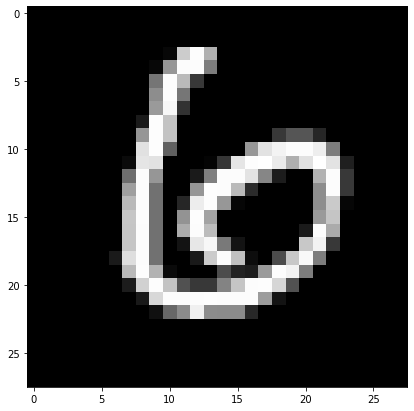

vecteur de probas :  [4.8965676e-04 9.7074846e-09 4.1625549e-07 1.4310924e-09 4.2643583e-06
 3.1841343e-04 9.9991737e+01 1.2738210e-09 7.4539492e-03 9.8012727e-09]
classe prédite : 6 (proba=   99.99%)


In [35]:
print(x2_test[1].shape)
print((np.expand_dims(x2_test[0], axis=0)).shape)

ntotest = 11
plt.imshow(x_test[ntotest], cmap='gray', interpolation='none')
plt.show()
p = model.predict(np.expand_dims(x2_test[ntotest], axis=0))
print("vecteur de probas : ", p[0] * 100)  # Probabilités par class
c = np.argmax(p[0])
print("classe prédite : {} (proba={:8.2f}%)".format(c, p[0][c] * 100))

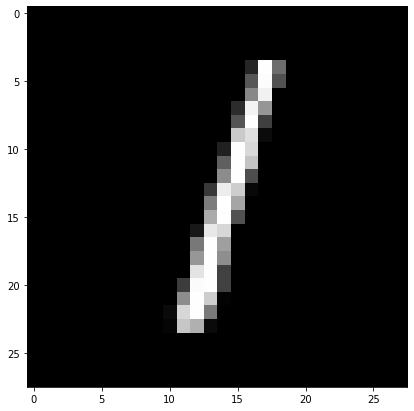

In [36]:
pall = model.predict(x2_test)
pbis = [(np.argmax(x), max(x)) for x in pall]
badexample = min(pbis, key=lambda x: x[1])[0]
plt.imshow(x_test[badexample], cmap='gray', interpolation='none')
plt.show()

1